<a href="https://colab.research.google.com/github/kahf10/DeepLearning/blob/main/KahfHussain_11_Huggingface_Text_Classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessment: Classifying authors with DistilBERT
Please use the HuggingFace Transformer library for author classification:
* use the DistilBERT architecture this time,
* collect data from 4 authors,
* create, train and evaluate a classifier with DistilBERT and 4 authors.



In [1]:
%%capture
!pip install tensorflow transformers
!python -m spacy download en

In [2]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle
import spacy
from urllib.request import urlretrieve
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

## 1. Exercise: Dataset acquisition

In [3]:
nlp = spacy.load("en_core_web_sm")

def sentencesSplit(raw_text):
  doc = nlp(raw_text)
  sentences = [sent.text for sent in doc.sents]
  return sentences


In [4]:
book1="http://www.gutenberg.org/files/2151/2151-0.txt" #The Works of Edgar Allan Poe, Volume 5
book2="https://www.gutenberg.org/cache/epub/70589/pg70589.txt" #Tarzan and the lost empire
book3 = 'https://www.gutenberg.org/cache/epub/11/pg11.txt' #Alice Adventures in Wonderland
book4 = 'https://www.gutenberg.org/cache/epub/2542/pg2542.txt' #A doll's house
urlretrieve(book1, 'book1.txt')
urlretrieve(book2, 'book2.txt')
urlretrieve(book3, 'book3.txt')
urlretrieve(book4, 'book4.txt')
book1_text = open("book1.txt", encoding='utf-8').read().lower()
book2_text = open("book2.txt", encoding='utf-8').read().lower()
book3_text = open("book3.txt", encoding='utf-8').read().lower()
book4_text = open("book4.txt", encoding='utf-8').read().lower()

In [7]:
book1_sents = sentencesSplit(book1_text)
book2_sents = sentencesSplit(book2_text)
book3_sents = sentencesSplit(book3_text)
book4_sents = sentencesSplit(book4_text) 

In [8]:
TRAIN_SIZE = 0.8
t_split_1  = int(TRAIN_SIZE*len(book1_sents))
t_split_2  = int(TRAIN_SIZE*len(book2_sents))
t_split_3  = int(TRAIN_SIZE * len(book3_sents))
t_split_4  = int(TRAIN_SIZE * len(book4_sents))

In [21]:
X_train = book1_sents[:t_split_1] + book2_sents[:t_split_2] + book3_sents[:t_split_3] + book4_sents[:t_split_4]
Y_train = np.concatenate((np.zeros((t_split_1)), np.ones((t_split_2)), np.full((t_split_3), 2), np.full((t_split_4), 3))) 
#Divided the training and test blocks because I was having some issues with setting up the test block

In [18]:
X_test  = book1_sents[t_split_1:] + book2_sents[t_split_2:] + book3_sents[t_split_3:] + book4_sents[t_split_4:]
Y_test  = np.concatenate((np.zeros((len(book1_sents) - t_split_1)), 
                          np.ones((len(book2_sents) - t_split_2)), 
                          np.full(len(book3_sents) - t_split_3, 2), 
                          np.full(len(book4_sents) - t_split_4, 3)))


# 2. Exercise: Data preparation

We are using [DisitlBERT](https://huggingface.co/transformers/model_doc/distilbert.html) model, in which we have to convert each sentence into a tuple containing the text's [input ids](https://huggingface.co/transformers/glossary.html#input-ids) and the corresponding [attention masks](https://huggingface.co/transformers/glossary.html#attention-mask). In order to do so, the corresponding tokizer can be used: [DistilBertTokenizer](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)

We trim or pad the processed sentences to MAX_LEN (due to `truncation=True` and `padding=True` parameters) - this is an easy solution to handle inputs with different lengths.

In [19]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 20

sample = X_train[100]

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
inputs = tokenizer(sample, max_length=MAX_LEN, truncation=True, padding=True)

print(f'sentence: \'{sample}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

sentence: 'there are, nevertheless, three or
      four female heads, of an ethereal beauty-portraits in the manner of sully.
      '
input ids: [101, 2045, 2024, 1010, 6600, 1010, 2093, 2030, 2176, 2931, 4641, 1010, 1997, 2019, 28855, 15879, 5053, 1011, 9668, 102]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


This transformation must be applied to each sentence in the corpus. Here's how we do it: `construct_encodings` maps the tokenizer to each `sentence` and aggregates them:

In [20]:
def construct_encodings(x, tokenizer, max_len, trucation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings_train = construct_encodings(X_train, tokenizer, max_len=MAX_LEN)
encodings_test  = construct_encodings(X_test, tokenizer, max_len=MAX_LEN)

Now we have to convert the `encodings` and `y` (which holds the classes of the authors) into a [Tensorflow Dataset object](https://www.tensorflow.org/api_docs/python/tf/data/Dataset):



In [22]:
def construct_tfdataset(encodings, y=None):
    if y is not None:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset_train = construct_tfdataset(encodings_train, Y_train)
tfdataset_test  = construct_tfdataset(encodings_test, Y_test)

Shuffle the training data and create batches.

In [23]:
BATCH_SIZE = 16

tfdataset_train = tfdataset_train.shuffle(len(X_train))
tfdataset_train = tfdataset_train.take(len(X_train))
tfdataset_test = tfdataset_test.take(len(X_test))
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

Our data is finally ready. Now we can do the fun part: model fitting!

# 3. Exercise: Fine-tuning the model

Fine-tuning the model is as easy as instantiating a model instance, [optimizer](https://developers.google.com/machine-learning/glossary#optimizer), and [loss](https://developers.google.com/machine-learning/glossary#loss), and then compiling/fitting:

In [33]:
N_EPOCHS = 2

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=4)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'], )

model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=tfdataset_test)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_119', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/2
575/575 [==============================] - 85s 107ms/step - loss: 0.4122 - accuracy: 0.8572 - val_loss: 0.6150 - val_accuracy: 0.7847
Epoch 2/2
575/575 [==============================] - 36s 62ms/step - loss: 0.1496 - accuracy: 0.9511 - val_loss: 0.7009 - val_accuracy: 0.7812


## 4. Exercise: Evaluation

Let's test our model with the test set and the default classification metrics.

In [34]:
print(model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE))

144/144 [==============================] - 3s 23ms/step - loss: 0.7009 - accuracy: 0.7812
{'loss': 0.7009397745132446, 'accuracy': 0.7812092304229736}


In [35]:
preds = model.predict(tfdataset_test, batch_size=BATCH_SIZE)
preds_classes = np.argmax(preds[0], axis=1)

144/144 [==============================] - 4s 19ms/step


In [36]:
print(classification_report(Y_test, preds_classes))

              precision    recall  f1-score   support

         0.0       0.66      0.86      0.75       613
         1.0       0.86      0.81      0.83       696
         2.0       0.82      0.57      0.67       292
         3.0       0.85      0.77      0.81       698

    accuracy                           0.78      2299
   macro avg       0.80      0.75      0.76      2299
weighted avg       0.80      0.78      0.78      2299



<Axes: >

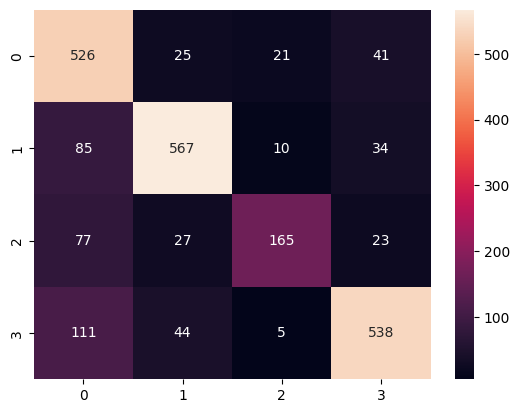

In [37]:
conf=confusion_matrix(Y_test, preds_classes)
sns.heatmap(conf, annot=True, fmt='d')